## Watershed



In [1]:
import dask
import dask.array as da
import numpy as np

In [2]:
def compute_mem_mb(shape):
    '''Determines memory consumption of an array with shape in MB'''
    from functools import reduce
    from operator import mul
    count = reduce(mul, shape, 1)
    return count * 8 / ( 1024 ** 2 )

def display(image):
    '''Shows an image in the Jupyter notebook.'''
    from skimage import io
    io.imshow(image)
    io.show()

def frac_to_zscore(frac):
    from scipy.stats import norm
    return norm.ppf(frac)

In [3]:
ndim = 2
chunk_len = 400
chunks = ndim * [chunk_len]
chunk_mem_mb = compute_mem_mb(chunks)
print("Chunk size (MB): {:.2f}".format(chunk_mem_mb))

Chunk size (MB): 1.22


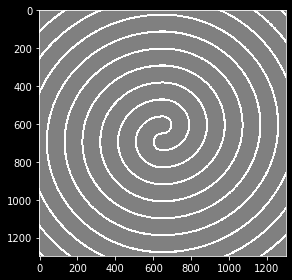

In [4]:
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
im = imread("./double_spiral.jpg")
im = rgb2gray(im)
im = im > threshold_otsu(im)
im = im + 1

salt = np.zeros_like(im)
salt[600, 650] = True
salt[700, 650] = True
im[600, 650] = 0
im[700, 650] = 0
max_edt = im.max()
edt = im / max_edt
display(edt)

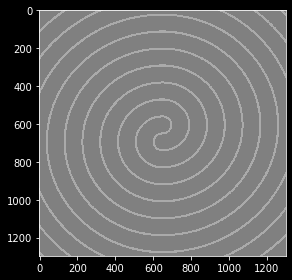

In [8]:
# hmax
from skimage.morphology import reconstruction
h = 1 / (1 + max_edt)
h_seed = edt - h
hmax = reconstruction(h_seed, edt, method='dilation')
display(hmax)

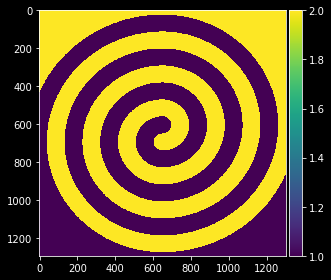

In [9]:
from skimage.measure import label
ws_markers, ws_label_max = label(salt, return_num=True)

from skimage.morphology import watershed
ws = watershed(hmax, markers=ws_markers)
display(ws)

In [10]:
from dask.distributed import Client
c = Client()
port = c.scheduler_info()['services']['dashboard']
print("Type `http://localhost:{port}` into the URL bar of your favorite browser to watch the following code in action on your machine in real time.".format(port=port))

C:\Users\wwarr\AppData\Local\Continuum\anaconda3\envs\dask_test\lib\site-packages\distributed\dashboard\core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)
Type `http://localhost:64429` into the URL bar of your favorite browser to watch the following code in action on your machine in real time.


C:\Users\wwarr\AppData\Local\Continuum\anaconda3\envs\dask_test\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
C:\Users\wwarr\AppData\Local\Continuum\anaconda3\envs\dask_test\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
C:\Users\wwarr\AppData\Local\Continuum\anaconda3\envs\dask_test\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:78: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


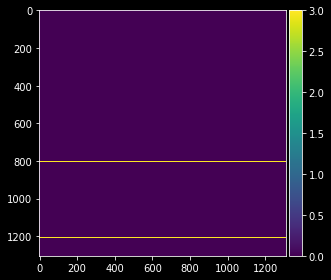

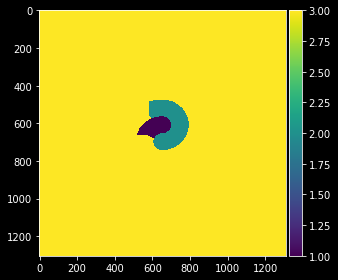

In [11]:
depth = 1
hmax_da = da.from_array(hmax, chunks=chunks)
hmax_op = da.overlap.overlap(hmax_da, depth=depth, boundary='nearest')
#display(hmax_op)

boundary_label = ws_label_max + 1
ws_markers_da = da.from_array(ws_markers, chunks=chunks)
ws_markers_op = da.overlap.overlap(ws_markers_da, depth=depth, boundary=boundary_label)
#display(labels_op)

def mask_overlap(chunk, depth, label):
    overlap = np.zeros_like(chunk)
    for i in range(0, chunk.ndim):
        idx = [slice(None)]*chunk.ndim
        r = np.array(range(0, chunk.shape[i]))
        idx[i] = (r[:depth], r[-depth:])
        overlap[tuple(idx)] = label
    return overlap

def build_full_markers(labels, depth, label):
    markers = mask_overlap(labels, depth, label)
    markers[labels > 0] = labels[labels > 0]
    return markers

ws_markers_op = ws_markers_op.map_blocks(lambda x: build_full_markers(x, depth, boundary_label), dtype=ws_markers_op.dtype)
display(ws_markers_op)

ws_fp = hmax_op.map_blocks(lambda x, y: watershed(x, markers=y), ws_markers_op, dtype=hmax_op.dtype)
display(ws_fp)

C:\Users\wwarr\AppData\Local\Continuum\anaconda3\envs\dask_test\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
C:\Users\wwarr\AppData\Local\Continuum\anaconda3\envs\dask_test\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:78: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "
C:\Users\wwarr\AppData\Local\Continuum\anaconda3\envs\dask_test\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
C:\Users\wwarr\AppData\Local\Continuum\anaconda3\envs\dask_test\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:78: UserWarning: Float image out of standard range; displaying image with stretched cont

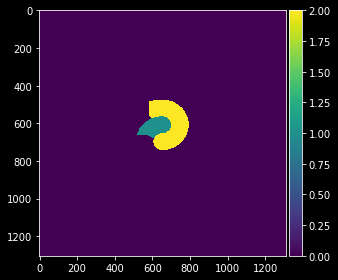

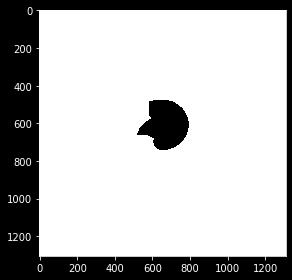

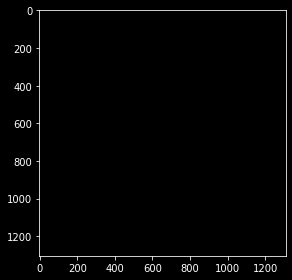

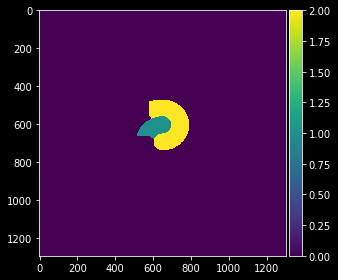

In [12]:
def remove_label(chunk, label):
    out = chunk.copy()
    out[out == label] = 0
    return out

ws_markers_sp = ws_fp.map_blocks(lambda x: remove_label(x, boundary_label))
ws_markers_sp = da.overlap.trim_overlap(ws_markers_sp, depth=depth)
ws_markers_sp = da.overlap.overlap(ws_markers_sp, depth=depth, boundary='nearest')
display(ws_markers_sp)

ws_mask = ws_fp == boundary_label
display(ws_mask)

ws_sp = hmax_op.map_blocks(lambda x, y, z: watershed(x, markers=y, mask=z), ws_markers_sp, ws_mask, dtype=ws_fp.dtype)
display(ws_sp)

def compose(fp_chunk, sp_chunk, mask_chunk):
    out = fp_chunk.copy()
    out[mask_chunk] = sp_chunk[mask_chunk]
    return out

ws_final = ws_fp.map_blocks(lambda x, y, z: compose(x, y, z), ws_sp, ws_mask, dtype=ws_fp.dtype)
ws_final = da.overlap.trim_overlap(ws_final, depth=depth)
display(ws_final)

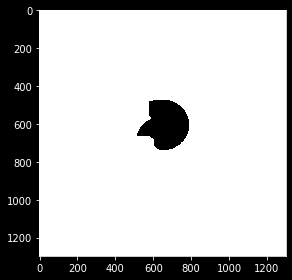

Error count: 1635379
Error fraction: 97.067%


In [13]:
# Validate
error = ~(ws == ws_final).compute()
display(error)

error_count = error.sum()
print("Error count: {:d}".format(error_count))
print("Error fraction: {:.3%}".format(error_count / error.size))